                          DecisionTreeClassifier                           
---------------------------------------------------------------------------------------------------------
   Dataset    |   5%   |  10%   |  15%   |  20%   |  25%   |  30%   |  35%   |  40%   |  45%   |  50%   |
---------------------------------------------------------------------------------------------------------
australian    | 72.61% | 74.63% | 75.52% | 77.53% | 77.97% | 79.86% | 83.05% | 81.29% | 80.14% | 82.91% |
balance-scale | 70.10% | 72.47% | 71.20% | 75.69% | 73.77% | 75.67% | 77.74% | 75.99% | 78.09% | 76.98% |
hypothyroid   | 94.94% | 96.31% | 97.77% | 99.18% | 99.21% | 99.42% | 99.42% | 99.52% | 99.34% | 99.20% |


                          BernoulliNB with priors                          
---------------------------------------------------------------------------------------------------------
   Dataset    |   5%   |  10%   |  15%   |  20%   |  25%   |  30%   |  35%   |  40%   |  45%   |  50%   

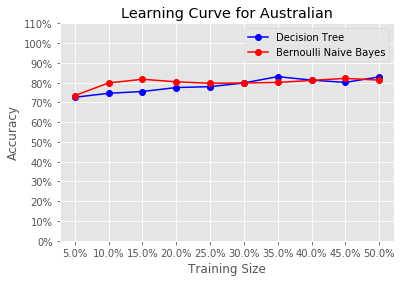

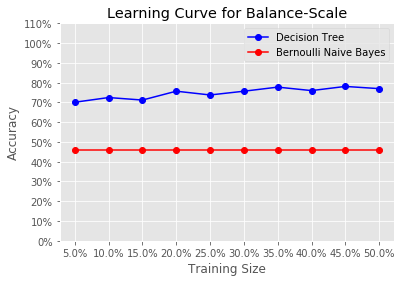

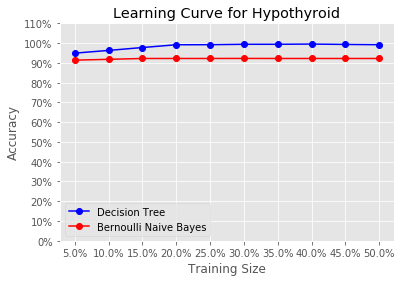

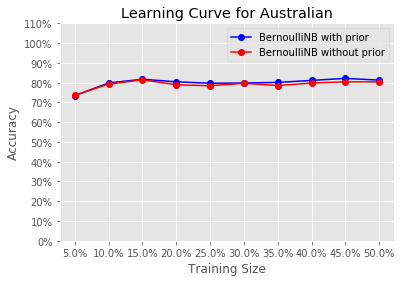

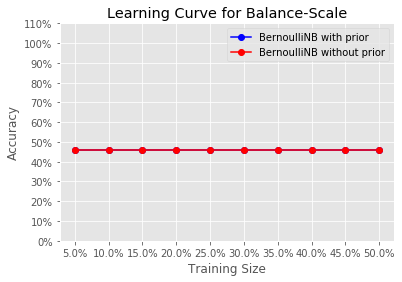

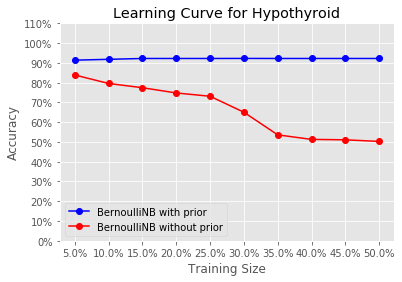

In data australian.arff, the best prior is {'fit_prior': True}, with grid score 0.827536231884058
In data balance-scale.arff, the best prior is {'fit_prior': True}, with grid score 0.4608
In data hypothyroid.arff, the best prior is {'fit_prior': True}, with grid score 0.922322375397667
   Pclass  Sex  Age  Siblings_Spouses_Aboard  Parents_Children_Aboard  \
0       3    1   20                        1                        0   
1       1    0   30                        1                        0   
2       3    0   20                        0                        0   
3       1    0   30                        1                        0   
4       3    1   30                        0                        0   

   Survived  
0         0  
1         1  
2         1  
3         1  
4         0  
Pclass                     0
Sex                        0
Age                        0
Siblings_Spouses_Aboard    0
Parents_Children_Aboard    0
Survived                   0
dtype: int64
The

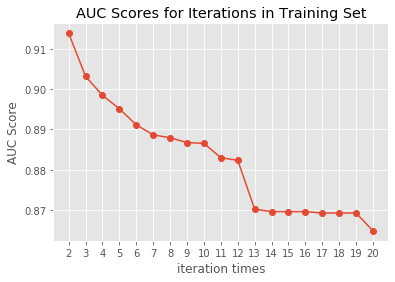

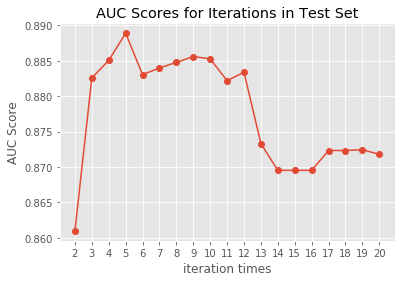

The numerator is 0.05073280721533258, the denominator is 0.1375422773393461
The probability is 0.36885245901639346


In [5]:
import numpy as np
from scipy.io import arff
import pandas as pd
from sklearn.base import TransformerMixin
from sklearn import tree
from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from sklearn.metrics import roc_auc_score
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
import sys
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
%matplotlib inline

# ------------------- FUNCTIONS FOR QUESTION 1 STARTS-----------------------------#

# fixed random seed
np.random.seed(1)
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

def label_enc(labels):
    le = preprocessing.LabelEncoder()
    le.fit(labels)
    return le

def load_data(path):
    dataset = arff.loadarff(path)
    data = pd.DataFrame(dataset[0])
    attr = np.array(data.columns)
    data = DataFrameImputer().fit_transform(data).values

    # mask categorical features
    masks = []
    for i in range(len(attr)-1):
        if isinstance(attr[i][1],float):
            masks.append(i)
    return data, masks

class DataFrameImputer(TransformerMixin):

    def fit(self, X, y=None):
        # Fill categorical columns with the highest frequency value, and
        # fill values columns with mean
        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)

def get_method_scores(data, method):
    X = data[:,0:data.shape[1]-1]
    lenc = label_enc(data[:,data.shape[1]-1])
    y = lenc.transform(data[:,data.shape[1]-1])
    train_sizes = np.array([0.05, .1, .15, .2, .25, .3, .35, .4, .45, .5])
    _, train_scores, test_scores = learning_curve(method, X, y, cv=5, 
                                                  train_sizes=train_sizes,
                                                  scoring=None, shuffle=False, random_state=0, 
                                                  error_score=0)
    return test_scores

# Modified to return the scores list
def test_method(method, title):
    # load data
    paths = ['australian','balance-scale','hypothyroid']
    scores = []

    for path in paths:
        score = []
        path += '.arff'
        data, masks = load_data(path)

        # training on data with different portions of training data
        score_array = get_method_scores(data, method)
        # we got a [num portions][num folds] array, need to avg them into 
        # a list of scores for each portion
        for ar in score_array:
            score.append(np.mean(ar)) # because we use 5-fold cross validation (cv=5)
        scores.append(score)

    # print the results
    method_name = method.__class__.__name__+' '+title
    header = "{:^75}".format(method_name) + '\n' + '-' * 105  + '\n' + \
    "{:^13} | {:^6} | {:^6} | {:^6} | {:^6} | {:^6} | {:^6} | {:^6} | {:^6} | {:^6} | {:^6} |" \
    .format("Dataset", "5%", "10%", "15%", "20%", "25%", "30%", "35%", "40%", "45%", "50%") + \
     '\n' + '-' * 105

    # print result table
    print(header)
    for i in range(len(scores)):
        print("{:<14}".format(paths[i]),end="")
        for j in range(len(scores[i])):
            print("| {:>6.2%} ".format(scores[i][j]),end="")
        print('|')
    print('\n')
    return scores

# Compare two test_score list data by plotting
def plot_cmp(scores1,scores2,label1,label2):
    paths = ['australian','balance-scale','hypothyroid']
    if(len(scores1)==0 or len(scores2)==0):
        raise ValueError('plot_all():The input list is empty')
    x_axis = np.arange(0.05,0.55,0.05)
    for i in range(len(paths)):
        plt.figure()
        plt.gca().xaxis.set_major_formatter(PercentFormatter(1)) # Set axis to be in percentage format
        plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
        plt.style.use('ggplot')
        plt.plot(x_axis,scores1[i],marker='o',color='blue',label=label1)
        plt.plot(x_axis,scores2[i],marker='o',color='red',label=label2)
        plt.xticks(np.arange(0.05,0.55,0.05))
        plt.yticks(np.arange(0,1.2,step=0.1))
        plt.legend()
        plt.xlabel('Training Size')
        plt.ylabel('Accuracy')
        plt.title('Learning Curve for {0}'.format(paths[i].title()))
        plt.savefig('{0}.png'.format(paths[i]),dpi=1000)
        plt.show()

#compare hyper-parameter choice by grid search
def grid_search_cmp(method,param_grid,paths):
    grid_search = GridSearchCV(method,param_grid,n_jobs=-1,cv=5)
    for path in paths:
        path += '.arff'
        data, masks = load_data(path)
        # We treat the whole file data as the training set
        train_x = data[:,0:data.shape[1]-1]
        lenc = label_enc(data[:,data.shape[1]-1])
        train_y = lenc.transform(data[:,data.shape[1]-1])
        grid_result = grid_search.fit(train_x,train_y)
        print("In data {0}, the best prior is {1}, with grid score {2}".\
             format(path,grid_result.best_params_,grid_result.best_score_))
                    
def question_1():
    dt_scores=test_method(DecisionTreeClassifier(random_state=0),'')
    ber_scores=test_method(BernoulliNB(),'with priors')
    ber_no_prior_scores = test_method(BernoulliNB(fit_prior=False),'without priors')
    plot_cmp(dt_scores,ber_scores,'Decision Tree','Bernoulli Naive Bayes')
    plot_cmp(ber_scores,ber_no_prior_scores,'BernoulliNB with prior','BernoulliNB without prior')

    # Grid Search Cross Validation Part
    fit_prior = [True,False]
    param_grid = dict(fit_prior=fit_prior)
    paths = ['australian','balance-scale','hypothyroid']
    grid_search_cmp(BernoulliNB(),param_grid,paths)
    
#-------------------------FUNCTIONS FOR QUESTION 1 ENDS--------------------------#

#-----------------------FUNCTIONS FOR QUESTION 2 STARTS--------------------------#
def preprocess(filename):
    TEST_SIZE=0.3
    data = pd.read_csv(filename)
    print(data.head(5))
    print(data.isnull().sum()) #check whether there are null value data
    #Apply min-max normalisation
    cols = data.columns
    np_scaled = preprocessing.MinMaxScaler().fit_transform(data)
    data = pd.DataFrame(np_scaled,columns=cols)
    # Split training set and test set
    data_x = data.iloc[:,:-1]
    data_y = data.iloc[:,-1]
    train_x,test_x,train_y,test_y= train_test_split(data_x,data_y,test_size=TEST_SIZE,shuffle=False)
    return (train_x,test_x,train_y,test_y)

def get_accuracy_score(train_x,test_x,train_y,test_y):
    clf = DecisionTreeClassifier().fit(train_x,train_y)
    print('The accuracy score for training set is',accuracy_score(train_y,clf.predict(train_x)))
    print('The accuracy score for test set is',accuracy_score(test_y,clf.predict(test_x)))
    return None

# find the optimal min_samples_leaf hyper-parameter by using AUC score
def optimal_min_samples_leaf(train_x,test_x,train_y,test_y):
    AUC_scores_train=[]
    AUC_scores_test=[]
    for i in range(2,21):
        clf = DecisionTreeClassifier(min_samples_leaf=i).fit(train_x,train_y)
        AUC_scores_train.append([i,roc_auc_score(train_y,clf.predict_proba(train_x)[:,1])])
        AUC_scores_test.append([i,roc_auc_score(test_y,clf.predict_proba(test_x)[:,1])])
    sorted_train_AUC = sorted(AUC_scores_train,reverse=True,key=lambda x:x[1])
    sorted_test_AUC = sorted(AUC_scores_test,reverse=True,key=lambda x:x[1])
    print('For training set, the optimal number of min_samples_leaf is {0:0}, with AUC score {1:.5}'\
         .format(sorted_train_AUC[0][0],sorted_train_AUC[0][1]))
    print('For test set, the optimal number of min_samples_leaf is {0:0}, with AUC score {1:.5}'\
         .format(sorted_test_AUC[0][0],sorted_test_AUC[0][1]))
    return (AUC_scores_train,AUC_scores_test)

def plot_AUC(AUC_score,title):
    x_axis = np.arange(2,21).astype(int)
    plt.figure()
    plt.style.use('ggplot')
    plt.plot(x_axis,[y[1] for y in AUC_score],marker='o')
    plt.xticks(np.arange(2,21,step=1))
    plt.xlabel('iteration times')
    plt.ylabel('AUC Score')
    plt.title('AUC Scores for Iterations in {0} Set'.format(title.title()))
    plt.savefig('{0}.png'.format(title.title()),dpi=1000)
    plt.show()
    
# compute the probability in part D
def probability():
    #reload data
    data = pd.read_csv('titanic.csv')
    numerator = len(data[(data.Survived==1)&(data.Sex==1)&(data.Pclass==1)])/len(data)
    denominator = len(data[(data.Sex==1)&(data.Pclass==1)])/len(data)
    print('The numerator is {0}, the denominator is {1}'.format(numerator,denominator))
    print('The probability is',numerator/denominator)


def question_2():
    train_x,test_x,train_y,test_y = preprocess('titanic.csv')
    get_accuracy_score(train_x,test_x,train_y,test_y)
    AUC_scores_train,AUC_scores_test = optimal_min_samples_leaf(train_x,test_x,train_y,test_y)
    plot_AUC(AUC_scores_train,'training')
    plot_AUC(AUC_scores_test,'test')
    probability()    
#-------------------------FUNCTIONS FOR QUESTION 2 ENDS--------------------------#

def main():
    question_1()
    question_2()
    
if __name__=="__main__":
    main()